In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\Arpan Basu Sachdeva\Downloads\sih\Electricity_Dataset.csv")

In [3]:
df

,Day,Month,Year,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,Hourly Demand Met (in MW)
0,1,1,2023,0,7.4,7.0,97,0.0,0,0.0,1019.9,5,2252.78
1,1,1,2023,1,7.7,7.1,96,0.0,249,1.8,1020.4,5,2013.40
2,1,1,2023,2,7.9,7.1,95,0.0,242,1.8,1021.1,5,1872.10
3,1,1,2023,3,9.8,9.3,97,0.0,270,5.4,1021.9,5,1806.61
4,1,1,2023,4,11.7,9.8,88,0.0,265,5.5,1021.9,5,1855.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11659,30,4,2024,19,25.1,12.7,46,0.0,283,3.7,1002.1,1,3937.19
11660,30,4,2024,20,24.6,12.5,47,0.0,281,1.8,1001.7,1,3753.42
11661,30,4,2024,21,24.6,12.5,47,0.0,270,9.4,1001.3,1,3543.18
11662,30,4,2024,22,23.8,12.1,48,0.0,289,1.8,1001.4,1,3505.90


In [4]:
time_data = []
elec_demand = []
for index, row in df.head(80).iterrows():
    # Concatenate the first 4 columns and convert them to string with '-' separator
    values = [int(x) if isinstance(x, (int, float)) else x for x in row[:4]]
    concatenated_string = '-'.join(map(str, values))
    
    # Append the concatenated string to the list
    time_data.append(concatenated_string)
    elec_demand.append(int(row[-1]))
    
len(time_data), len(elec_demand)

(80, 80)

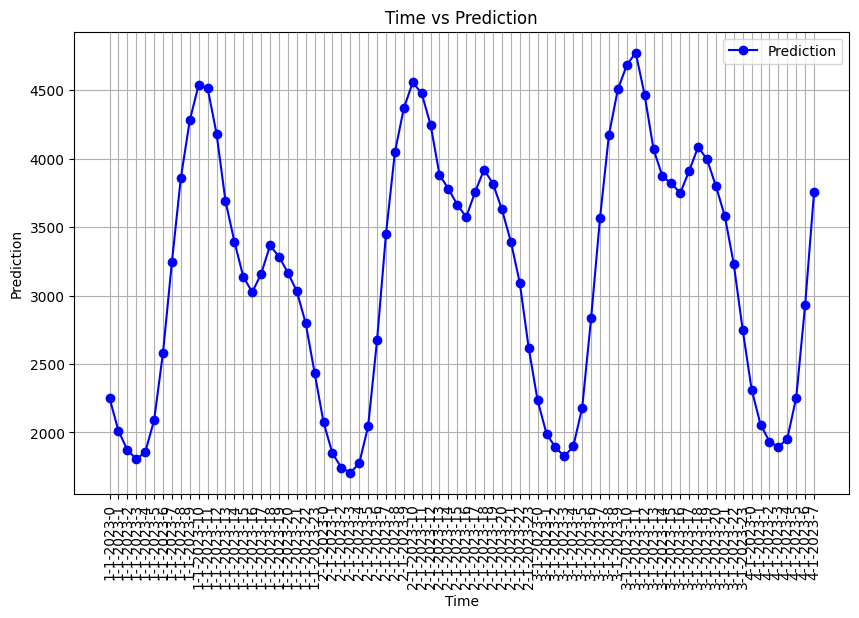

In [5]:
plt.figure(figsize=(10, 6))

# Plot time vs pred
plt.plot(time_data, elec_demand, marker='o', linestyle='-', color='b', label='Prediction')

# Add title and labels
plt.title('Time vs Prediction')
plt.xlabel('Time')
plt.ylabel('Prediction')

plt.xticks(rotation=90)
# Add grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [6]:
subset = df[:]
subset.drop(
    columns=['Day', 'Month', 'Year', 'time'],
    inplace=True
)

In [7]:
subset

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,Hourly Demand Met (in MW)
0,7.4,7.0,97,0.0,0,0.0,1019.9,5,2252.78
1,7.7,7.1,96,0.0,249,1.8,1020.4,5,2013.40
2,7.9,7.1,95,0.0,242,1.8,1021.1,5,1872.10
3,9.8,9.3,97,0.0,270,5.4,1021.9,5,1806.61
4,11.7,9.8,88,0.0,265,5.5,1021.9,5,1855.44
...,...,...,...,...,...,...,...,...,...
11659,25.1,12.7,46,0.0,283,3.7,1002.1,1,3937.19
11660,24.6,12.5,47,0.0,281,1.8,1001.7,1,3753.42
11661,24.6,12.5,47,0.0,270,9.4,1001.3,1,3543.18
11662,23.8,12.1,48,0.0,289,1.8,1001.4,1,3505.90


In [8]:
data = subset
features = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco']
target = 'Hourly Demand Met (in MW)'

In [9]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(data[features])
y = scaler_y.fit_transform(data[[target]])

# Create sequences for LSTM
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24 
X_seq, y_seq = create_sequences(X, y, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [10]:
class ElectricityLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ElectricityLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Set hyperparameters
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100
batch_size = 32

In [24]:
model = ElectricityLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 0.0044
Epoch [20/100], Loss: 0.0040
Epoch [30/100], Loss: 0.0033
Epoch [40/100], Loss: 0.0019
Epoch [50/100], Loss: 0.0021
Epoch [60/100], Loss: 0.0017
Epoch [70/100], Loss: 0.0011
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004
Test Loss: 0.0007


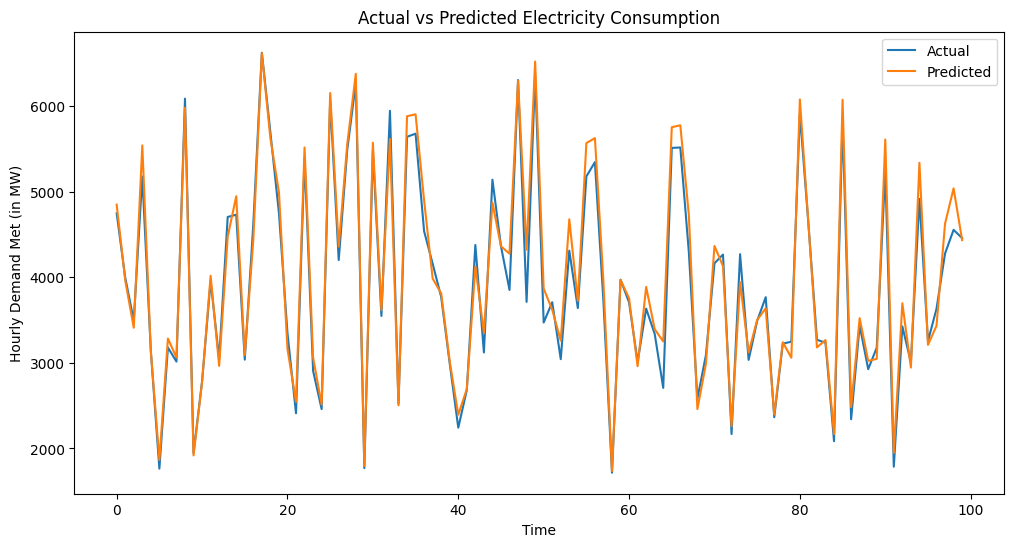

In [12]:
test_predictions = scaler_y.inverse_transform(test_predictions.numpy())
y_test_actual = scaler_y.inverse_transform(y_test.numpy())

# Plot actual vs predicted values for the first 100 test samples
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:100], label='Actual')
plt.plot(test_predictions[:100], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Hourly Demand Met (in MW)')
plt.title('Actual vs Predicted Electricity Consumption')
plt.legend()
plt.show()

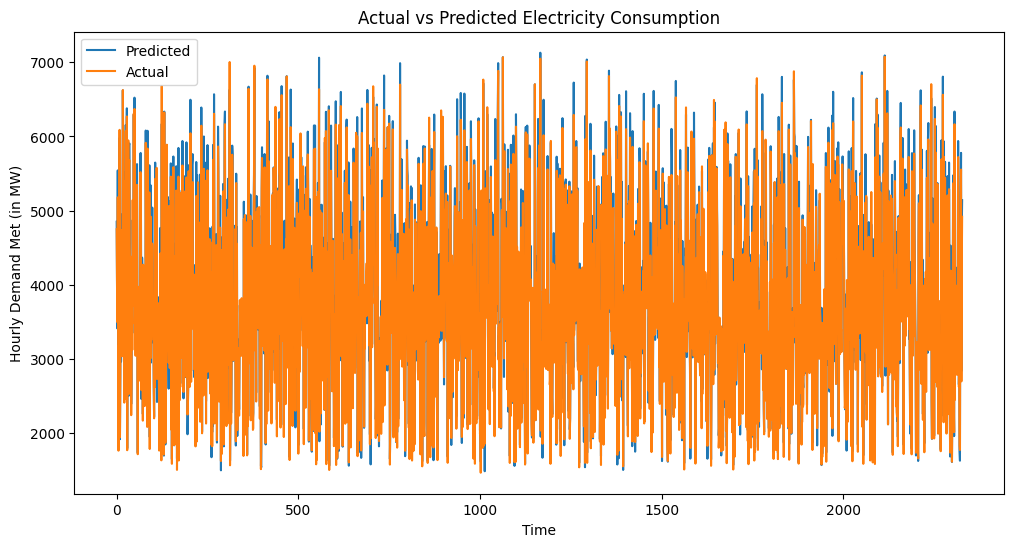

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(test_predictions[:], label='Predicted')
plt.plot(y_test_actual[:], label='Actual')

plt.xlabel('Time')
plt.ylabel('Hourly Demand Met (in MW)')
plt.title('Actual vs Predicted Electricity Consumption')
plt.legend()
plt.show()

R² Score: 0.9715


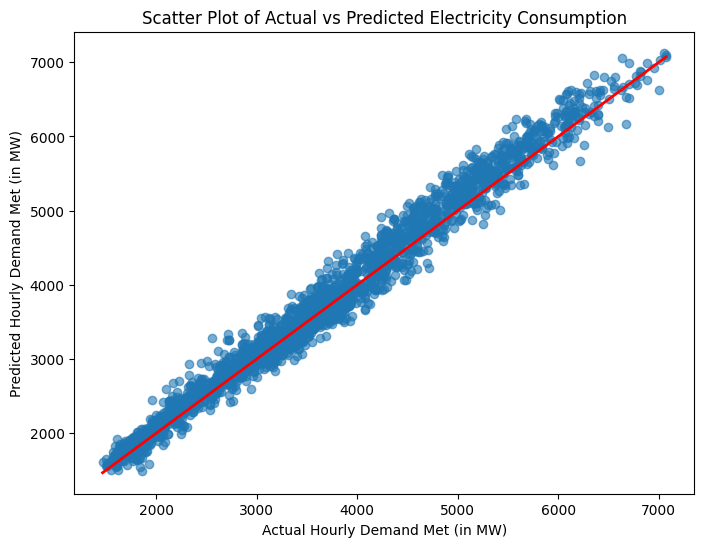

In [14]:
from sklearn.metrics import r2_score

# Ensure test_predictions and y_test_actual are reshaped correctly
test_predictions = test_predictions.reshape(-1, 1)
y_test_actual = y_test_actual.reshape(-1, 1)

# Calculate R² score
r2 = r2_score(y_test_actual, test_predictions)
print(f'R² Score: {r2:.4f}')

# Additional visualization: Scatter plot of Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, test_predictions, alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linewidth=2)  # Line of perfect prediction
plt.xlabel('Actual Hourly Demand Met (in MW)')
plt.ylabel('Predicted Hourly Demand Met (in MW)')
plt.title('Scatter Plot of Actual vs Predicted Electricity Consumption')
plt.show()


In [15]:
import pickle
import torch

# Assuming your model is loaded_model
state_dict = model.state_dict()

# Save the state_dict to a .pkl file
with open(r"C:\Users\Arpan Basu Sachdeva\Downloads\sih\model_state_dict.pkl", 'wb') as f:
    pickle.dump(state_dict, f)


In [16]:
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [17]:
import pickle

def load_model_state_dict(model, state_dict_path):
    with open(state_dict_path, 'rb') as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)
    model.eval()  # Set the model to evaluation mode
    return model


In [18]:
with open(r"C:\Users\Arpan Basu Sachdeva\Downloads\sih\model_state_dict.pkl", 'rb') as f:
    state_dict = pickle.load(f)

# Load the scalers
with open(r"C:\Users\Arpan Basu Sachdeva\Downloads\sih\scaler_X.pkl", 'rb') as f:
    scaler_X = pickle.load(f)

with open(r"C:\Users\Arpan Basu Sachdeva\Downloads\sih\scaler_y.pkl", 'rb') as f:
    scaler_y = pickle.load(f)


In [19]:
def predict(model, inputs, scaler_X, scaler_y):
    model.eval()  # Set the model to evaluation mode

    # Prepare the input data
    input_data = np.array(inputs).reshape(1, -1)
    input_data = scaler_X.transform(input_data)  # Use transform instead of fit_transform
    input_tensor = torch.FloatTensor(input_data).unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        prediction = model(input_tensor)
    
    # Inverse transform the prediction to get the original scale
    prediction = scaler_y.inverse_transform(prediction.numpy())
    
    return prediction[0][0]

In [21]:
from datetime import datetime, timedelta
from meteostat import Point, Hourly

In [22]:
# Set time period
start_date = datetime.now()
end_date = datetime.now() + timedelta(15)

delhi = Point(28.6139, 77.2090)

# Get hourly data
future = Hourly(delhi, start_date, end_date)
future = future.fetch()

# Drop unnecessary columns
future.drop(columns=['snow', 'wpgt', 'tsun'], inplace=True)

# Fill missing values with the mean of each column
future.fillna(future.mean(), inplace=True)

# Print the DataFrame
print(future)
time = []
pred = []
# Traverse each row and print values as a list
for index, row in future.iterrows():
    # Convert the row to a list
    row_values = row.tolist()
    # Print the row values
    print(f"Row index: {index}")
    prediction = predict(model, row_values, scaler_X, scaler_y)
    print(prediction)
    time.append(index)
    pred.append(prediction)

                     temp  dwpt   rhum       prcp   wdir  wspd    pres  \
time                                                                     
2024-09-12 11:00:00  26.5  26.0   97.0   3.500000  343.0   7.4   998.4   
2024-09-12 12:00:00  26.1  25.6   97.0   2.400000  325.0   9.3   998.1   
2024-09-12 13:00:00  26.0  25.7   98.0   1.100000  313.0   9.3   998.6   
2024-09-12 14:00:00  25.8  25.6   99.0   0.900000  291.0   9.3   999.1   
2024-09-12 15:00:00  25.7  25.7  100.0  11.600000  259.0   9.3   999.6   
...                   ...   ...    ...        ...    ...   ...     ...   
2024-09-21 11:00:00  33.8  24.4   58.0   1.695455   39.0   7.4  1002.8   
2024-09-21 12:00:00  33.3  24.8   61.0   1.695455   68.0   5.5  1002.4   
2024-09-21 13:00:00  32.2  24.8   65.0   1.695455   80.0   3.7  1003.0   
2024-09-21 14:00:00  31.0  25.1   71.0   1.695455   93.0   3.7  1003.6   
2024-09-21 15:00:00  29.9  25.4   77.0   1.695455  105.0   1.8  1004.1   

                         coco  
time 

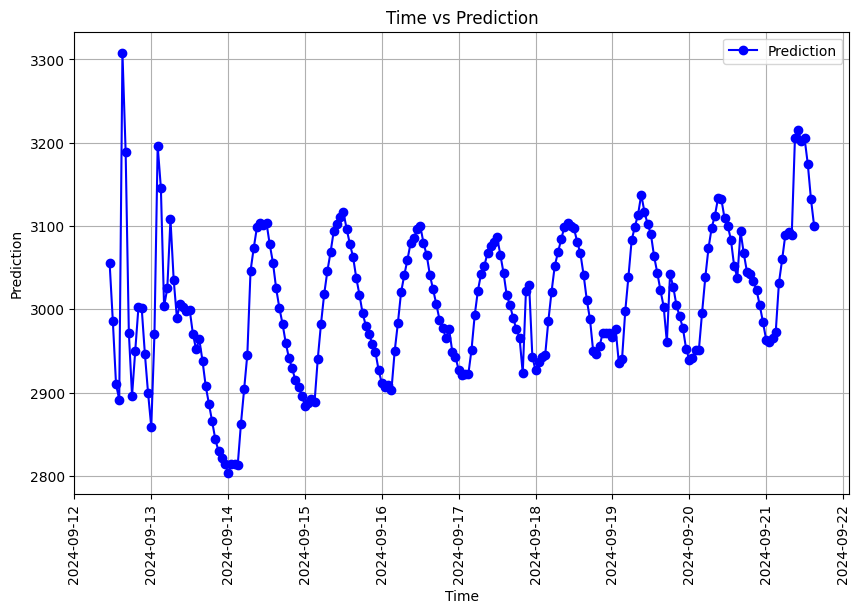

In [23]:
plt.figure(figsize=(10, 6))

# Plot time vs pred
plt.plot(time, pred, marker='o', linestyle='-', color='b', label='Prediction')

# Add title and labels
plt.title('Time vs Prediction')
plt.xlabel('Time')
plt.ylabel('Prediction')

plt.xticks(rotation=90)
# Add grid
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()